In [2]:
## Musical following study
# Script extracting amplitude envelopes from .wav files
# Written by Lucas Klein - June 2020
# Last edited - January 2022

In [11]:
# Import functions

%reset -f
#from playsound import playsound # this command function isn't found for some reason?
## I tried to update and reinstall anaconda python, but can't update to latest version (10.2.3)
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os
import sys

print(sys.version) # Jupyter is using "Python" (Python2?) (not Python3) version 3.9.7
## But the current version is Python3 version 3.10.2

os.chdir('/Users/lucas/Desktop/Following/')
print(os.getcwd())

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
/Users/lucas/Desktop/Following


In [13]:
## Set folder locations --- CHANGE THESE VARIABLES

piece = 'In The Garden/' # Danny Boy/ or In The Garden/
section = 'whole/' # whole/ for whole piece, 15_2, 22_1, 22_2, 22_3

## Find the .wav files in the DATA folder
# There is one folder for each piece, each which contains a folder for each section
data_folder = '/Users/lucas/Desktop/Following/DATA/' + piece
wav_perfs = data_folder + 'Performance_' + section
wav_stims = data_folder + 'Stim_out_' + section

# Set folder to save the outputs, .npy files and .txt files, inside the ANALYSIS folder
npys_perfs = '/Users/lucas/Desktop/Following/ANALYSIS/' + piece + 'Npys_P' + section
npys_stims = '/Users/lucas/Desktop/Following/ANALYSIS/' + piece + 'Npys_S' + section
txts_perfs = '/Users/lucas/Desktop/Following/ANALYSIS/' + piece + 'Txts_P' + section
txts_stims = '/Users/lucas/Desktop/Following/ANALYSIS/' + piece + 'Txts_S' + section

participants = os.listdir(wav_perfs)
participants.sort()
participants.pop(0) # This takes the '.DS_Store' entry off the list

print(section)
print(participants)
txts_perfs

whole/
['Part1', 'Part2', 'Part3', 'Part4', 'Part5', 'Part6', 'Part7', 'Part8']


'/Users/lucas/Desktop/Following/ANALYSIS/In The Garden/Txts_Pwhole/'

In [14]:
## Function that uses wavfile.read to extract data from .wav files

def get_sound(trial):
    sf, a = scipy.io.wavfile.read(trial) # sampling rate SHOULD be 44.1 kHz
    # a is the data returned as a Numpy array. For 24-bit PCM .wav file, Numpy data type is int16
    
    t_samples = len(a) # number of time samples
    t_sec = np.arange(t_samples)*(1/sf) # total length of .wav file in seconds
    
    amp_env = np.array(a)
    
    return amp_env, t_samples, t_sec, sf

In [15]:
## EXTRACT AMPLITUDE ENVELOPES
# Loop through participants in data_folder
# For each participant, loop through all trials
# For each trial, read data, detect sampling rate, extract amp env, and save output as .npy

sampling_rates = [] # empty list of sampling rates

for participant in participants:
    participant_folder_perf = wav_perfs + participant
    participant_folder_stim = wav_stims + participant
    filenames_perf = glob.glob(participant_folder_perf + "/*.wav") # make a list of the the .wav files
    filenames_stim = glob.glob(participant_folder_stim + "/*.wav") # make a list of the the .wav files
    filenames_perf.sort()
    filenames_stim.sort()
    
    # IMPORTANT! Make sure object filenames lists trials in the correct order
    # Depending on how participants label their recordings, this list could be in a wonky order
    # This is very important when checking to see how Granger changes over course of trials
    #print(filenames_perf);
    #print(filenames_stim)
    
    ## Loop through performance trials
    for triali in filenames_perf:
        trial_num = filenames_perf.index(triali) + 1 # add 1 to avoid having a "Trial 0"
        rec, t_samples, t_sec, sf_triali = get_sound(triali)
        
        sampling_rates += [[sf_triali]] # Add this trial's sampling rate to the list
        
        np.save(npys_perfs + '{}/Trial_{}_perf.npy'.format(participant,trial_num),rec) # Save amp env as .npy file
        
        
    ## Loop through stimulus trials
    for trialis in filenames_stim:
        trial_num = filenames_stim.index(trialis) + 1 # add 1 to avoid having a "Trial 0"
        stim, t_samples, t_sec, sf_triali = get_sound(trialis)
        
        np.save(npys_stims + '{}/Trial_{}_stim.npy'.format(participant,trial_num),stim) # Save amp env as .npy file

In [16]:
print(rec)
print(stim)
# sound = Numpy array of values
# n_samples = number of samples
# t_sec = length of .wav file in seconds
# sampling_rates now lists the sampling rates of each trial so we can make sure they're all 44.1 kHz
section

[-56   5  11 ...   1   3   2]
[  -7   -7   -6 ... -363 -346 -303]


'whole/'

In [17]:
# Check that sampling rates are all 44100
print(sampling_rates)
print(t_samples)
print(max(t_sec))

[[44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100], [44100]]
4144365
93.97650793650794


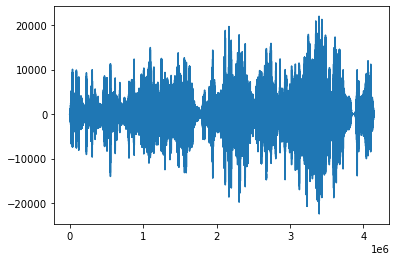

In [18]:
# Look at sound envelopes
#plt.plot(rec)
plt.plot(stim)

In [19]:
from scipy import signal
## Design butterworth filter
# filter order = 3, critical freq = .001
# For LP or HP filters, critical freq is a scalar.

b, a = signal.butter(3, 0.001) # default is 'lowpass'
# 3 = third order filter
# .001 = critical frequency
## For Butterworth, this is the point at which gain drops to 1/sqrt(2)
## that of the passband (the “-3 dB point”).

In [20]:
# This can take ~15-20 minutes to run...

## LOAD saved .npy files back into script as objects
# For each participant, loop through all trials
# For each trial, load the .npy file, take it's absolute value, and apply the filter
# Then save each trial it as a .txt file in a different folder

for participant in participants:
    participant_folder_perf = npys_perfs + participant
    participant_folder_stim = npys_stims + participant
    filenames_perf = glob.glob(participant_folder_perf + "/*.npy") # make a list of the .npy files
    filenames_stim = glob.glob(participant_folder_stim + "/*.npy") # make a list of the stimulus .npy files
    filenames_perf.sort()
    filenames_stim.sort()
    
    ## Loop through performance trials
    for triali in filenames_perf:
        trial_num = filenames_perf.index(triali) + 1 # add 1 to avoid having a "Trial 0"
        l = np.load(triali)
        m = np.abs(l) # data to be filtered
        rec_filt = signal.filtfilt(b, a, m, axis=0) # b and a are filter parameters from above, m is data array
        np.savetxt(txts_perfs + '{}/Trial_{}_perf.txt'.format(participant,trial_num),rec_filt)
        
    ## Loop through stimulus trials
    for trialis in filenames_stim:
        trial_num = filenames_stim.index(trialis)+1 # add 1 to avoid having a "Trial 0"
        l = np.load(trialis)
        m = np.abs(l)
        stim_filt = signal.filtfilt(b, a, m, axis=0) # b and a are filter parameters from above, m is data array
        np.savetxt(txts_stims + '{}/Trial_{}_stim.txt'.format(participant,trial_num),stim_filt)

[ 9.61540559  9.60589688  9.59638719 ... 11.41660338 11.41660335
 11.41660332]
[2.45820795 2.50551607 2.55282704 ... 7.19040347 7.19040338 7.1904033 ]


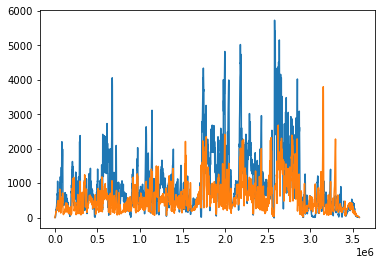

In [10]:
## Look at filtered time series
print(rec_filt)
print(stim_filt)
plt.plot(rec_filt)
plt.plot(stim_filt)
plt.show()

In [12]:
## Correlate two time series

corr = np.correlate(rec_filt,stim_filt)
corr

# I think they need to be truncated

ValueError: object too deep for desired array

In [343]:
# np.size(corr)

1

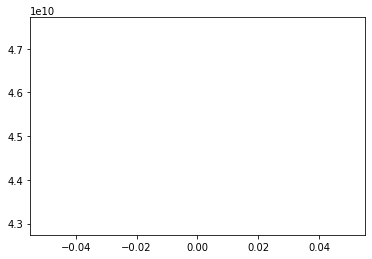

In [344]:
# plt.plot(corr)